In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

## NIST data

In [2]:
import pandas as pd

# Load the data from nist.txt
nist_df = pd.read_csv('nist.txt', header=None, names=["e", "mu", "mu_en"])

# Display the table
nist_df.head()

,e,mu,mu_en
0,0.001000,3184.0,3180.0
1,0.001500,1105.0,1102.0
2,0.002000,512.0,509.3
3,0.003000,170.3,168.2
4,0.003203,142.4,140.3


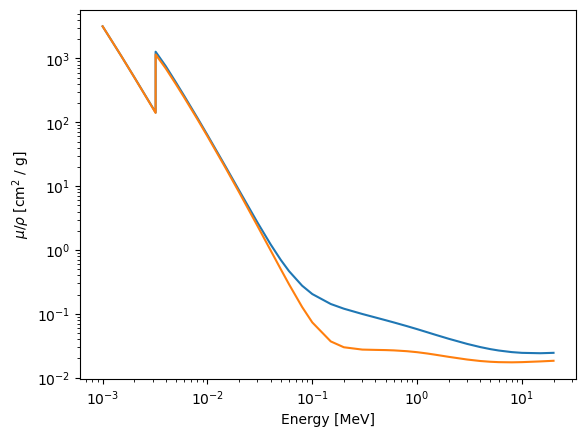

In [3]:
plt.loglog(nist_df["e"], nist_df["mu"])
plt.loglog(nist_df["e"], nist_df["mu_en"])
plt.xlabel(r"Energy [MeV]")
plt.ylabel(r"$\mu / \rho$ [cm$^2$ / g]")
plt.show()

The mean free path is given by $\lambda = 1 / [ (\mu / \rho) \cdot \rho ]$, where $\rho \sim 1.4 \, \text{g / cm}^3$ for Argon.

In [4]:
rho = 1.4 # g / cm^3
mfp = 1 / (nist_df["mu"] * rho)

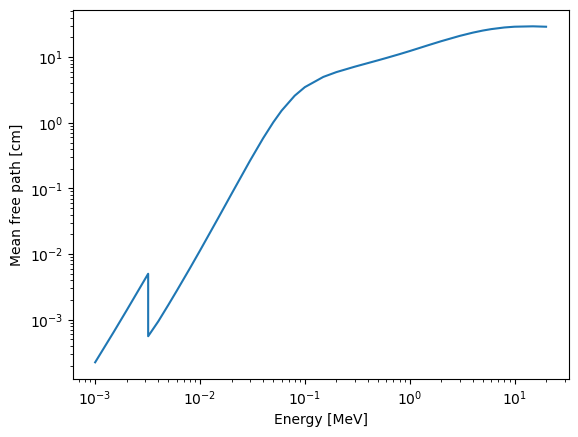

In [5]:
plt.loglog(nist_df["e"], mfp)
plt.xlabel(r"Energy [MeV]")
plt.ylabel(r"Mean free path [cm]")
plt.show()

## Photon leaving detector

LArIAT has dimensions given by x: 47 cm, y: 40 cm, z: 90 cm

In [6]:
det_x = 37
det_y = 40
det_z = 90

Then, we want to specify the starting point of the photon, the direction it is going, and its energy.

In [7]:
x0, y0, z0 = 18, 20, 10  
dx, dy, dz = 0.3, 0, 1
E = 10.0 # MeV

In [8]:
norm = np.sqrt(dx**2 + dy**2 + dz**2)
dx, dy, dz = dx/norm, dy/norm, dz/norm

In [9]:
def compute_exit_distance(x0, y0, z0, dx, dy, dz, det_x, det_y, det_z):
    bounds = [(0, det_x), (0, det_y), (0, det_z)]
    pos = np.array([x0, y0, z0])
    dir = np.array([dx, dy, dz])
    tmin, tmax = -np.inf, np.inf
    for i in range(3):
        if dir[i] != 0:
            t1 = (bounds[i][0] - pos[i]) / dir[i]
            t2 = (bounds[i][1] - pos[i]) / dir[i]
            t_near, t_far = min(t1, t2), max(t1, t2)
            tmin = max(tmin, t_near)
            tmax = min(tmax, t_far)
    if tmax < tmin or tmax < 0:
        return 0  # No intersection or already outside
    return max(0, tmax)

In [10]:
L = compute_exit_distance(x0, y0, z0, dx, dy, dz, det_x, det_y, det_z)

# Get mean free path for given energy
lambda_interp = interp1d(
    nist_df['e'],
    1 / (nist_df['mu'] * rho),
    bounds_error=False,
    fill_value=(
        (1 / (nist_df['mu'] * rho)).iloc[0],
        (1 / (nist_df['mu'] * rho)).iloc[-1]
    )
)
lambda_E      = lambda_interp(E)

# Probability photon leaves the detector
P_leave = np.exp(-L / lambda_E)
print(f'Photon path length in detector: {L:.2f} cm')
print(f'Mean free path at {E} MeV: {lambda_E:.2f} cm')
print(f'Probability photon leaves: {P_leave:.3f}')

Photon path length in detector: 66.12 cm
Mean free path at 10.0 MeV: 29.14 cm
Probability photon leaves: 0.103


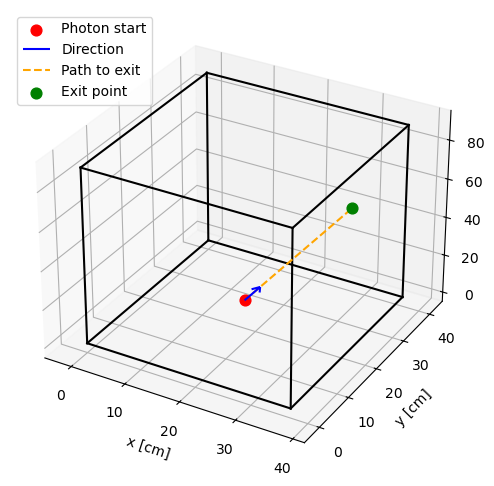

In [11]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Draw detector box
def draw_box(ax, det_x, det_y, det_z):
    # Vertices of the box
    r = [0, det_x]
    s = [0, det_y]
    t = [0, det_z]
    for x in r:
        for y in s:
            ax.plot([x, x], [y, y], [0, det_z], color='k', alpha=1)
    for x in r:
        for z in t:
            ax.plot([x, x], [0, det_y], [z, z], color='k', alpha=1)
    for y in s:
        for z in t:
            ax.plot([0, det_x], [y, y], [z, z], color='k', alpha=1)
draw_box(ax, det_x, det_y, det_z)

# Plot photon start point
ax.scatter([x0], [y0], [z0], color='red', s=60, label='Photon start')

# Plot direction arrow
arrow_length = 10
ax.quiver(x0, y0, z0, dx, dy, dz, length=arrow_length, color='blue', normalize=True, label='Direction')

# Compute exit point
exit_point = np.array([x0, y0, z0]) + L * np.array([dx, dy, dz])
ax.plot([x0, exit_point[0]], [y0, exit_point[1]], [z0, exit_point[2]], color='orange', linestyle='--', label='Path to exit')
ax.scatter([exit_point[0]], [exit_point[1]], [exit_point[2]], color='green', s=60, label='Exit point')

ax.set_xlim(-5, det_x+5)
ax.set_ylim(-5, det_y+5)
ax.set_zlim(-5, det_z+5)
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_zlabel('z [cm]')
ax.legend()
plt.show()

## Neutral pion decay

Now we want to consider the photons coming from the dominant neutral pion decay $\pi^0 \rightarrow \gamma + \gamma$.

In [12]:
def lorentz_boost(beta_vec, p4):
    beta  = np.array(beta_vec)
    beta2 = np.dot(beta, beta)
    gamma = 1.0 / np.sqrt(1 - beta2)

    # t' = \gamma * (t - \beta \cdot x)
    bp = np.dot(beta, p4[1:])
    p0 = gamma * (p4[0] - bp)

    # x' = x + ((\gamma - 1) (\hat \beta \cdot x) - \gamma t) \beta
    p_spatial = p4[1:] + ((gamma - 1) * bp / beta2 - gamma * p4[0]) * beta
    return np.concatenate(([p0], p_spatial))

In [13]:
def decay_pi0_to_2gamma(pion_p_lab):
    # Pion beta in lab
    pion_p_lab = np.array(pion_p_lab)
    pion_E     = pion_p_lab[0]
    pion_p     = pion_p_lab[1:]
    beta       = pion_p / pion_E if pion_E > 0 else np.zeros(3)

    # Random decay direction
    costheta = 2 * np.random.rand() - 1
    sintheta = np.sqrt(1 - costheta**2)
    phi      = 2 * np.pi * np.random.rand()
    n        = np.array([sintheta * np.cos(phi), sintheta * np.sin(phi), costheta])

    # Photon 4-momenta in rest frame
    m_pi0   = 134.9766 # MeV/c^2
    E_gamma = m_pi0 / 2
    p4_1    = np.array([E_gamma, E_gamma * n[0], E_gamma * n[1], E_gamma * n[2]])
    p4_2    = np.array([E_gamma, -E_gamma * n[0], -E_gamma * n[1], -E_gamma * n[2]])

    # Boost to lab frame
    p4_1_lab = lorentz_boost(beta, p4_1)
    p4_2_lab = lorentz_boost(beta, p4_2)
    return p4_1_lab, p4_2_lab

In [14]:
def photon_escape_probability(x0, y0, z0, photon_p4, det_x, det_y, det_z):
    # Direction
    px, py, pz = photon_p4[1:]
    norm       = np.sqrt(px**2 + py**2 + pz**2)
    dx, dy, dz = px/norm, py/norm, pz/norm
    
    # Energy and mean free path
    E        = photon_p4[0]
    L        = compute_exit_distance(x0, y0, z0, dx, dy, dz, det_x, det_y, det_z)
    lambda_E = lambda_interp(E)
    if (lambda_E < 0):
        return 1, L, 0

    return np.exp(-L / lambda_E), L, lambda_E

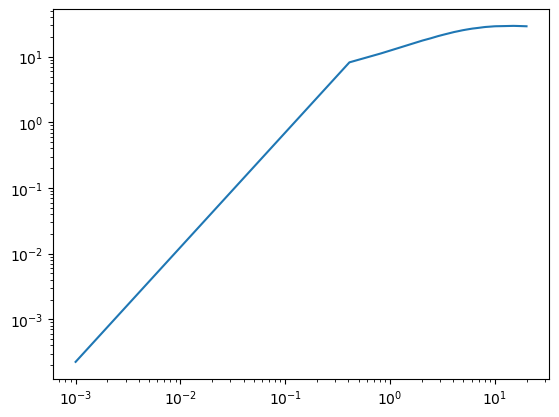

In [15]:
pion_pz_range = np.linspace(0.001, 20, 50)
aaa = lambda_interp(pion_pz_range)
plt.loglog(pion_pz_range, aaa)

In [16]:
pion_mass = 134.9766 # MeV / c^2
pion_px   = 0 # MeV / c
pion_pz   = 400 # MeV / c
pion_py   = 0 # MeV / c
pion_E    = np.sqrt(pion_mass**2 + pion_px**2 + pion_py**2 + pion_pz**2)

pion_p_lab      = [pion_E, pion_px, pion_py, pion_pz]
gamma1, gamma2  = decay_pi0_to_2gamma(pion_p_lab)
P1, L1, lambda1 = photon_escape_probability(x0, y0, z0, gamma1, det_x, det_y, det_z)
P2, L2, lambda2 = photon_escape_probability(x0, y0, z0, gamma2, det_x, det_y, det_z)

print("Incoming pion energy:", pion_E)
print(f"Photon 1: p = {gamma1[0]:.2f} MeV, path = {L1:.2f} cm, mfp = {lambda1:.2f} cm, escape prob = {P1:.3f}")
print(f"Photon 2: p = {gamma2[0]:.2f} MeV, path = {L2:.2f} cm, mfp = {lambda2:.2f} cm, escape prob = {P2:.3f}")

Incoming pion energy: 422.1595463181663
Photon 1: p = 135.90 MeV, path = 11.26 cm, mfp = 29.12 cm, escape prob = 0.679
Photon 2: p = 286.26 MeV, path = 10.25 cm, mfp = 29.12 cm, escape prob = 0.703


<function matplotlib.pyplot.show(close=None, block=None)>

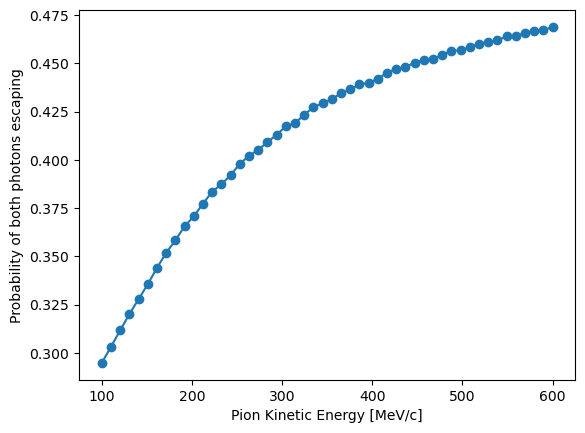

In [17]:
N_trials        = 10000
pion_pz_range   = np.linspace(100, 600, 50)
x0, y0, z0      = 18, 20, 10
prob_no_photons = []

for pz in pion_pz_range:
    pion_E     = np.sqrt(pz**2 + pion_mass**2)
    pion_p     = [pion_E, 0, 0, pz]
    no_photons = 0
    for _ in range(N_trials):
        gamma1, gamma2 = decay_pi0_to_2gamma(pion_p)
        prob1, L1, lambda_E1 = photon_escape_probability(x0, y0, z0, gamma1, det_x, det_y, det_z)
        prob2, L2, lambda_E2 = photon_escape_probability(x0, y0, z0, gamma2, det_x, det_y, det_z)
        no_photons += prob1 * prob2 / N_trials
    prob_no_photons.append(no_photons)

plt.plot(pion_pz_range, prob_no_photons, marker='o')
plt.xlabel("Pion Kinetic Energy [MeV/c]")
plt.ylabel("Probability of both photons escaping")
plt.show